## Preprocessing audio data sample





In [1]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Text(0.5, 1.0, 'Waveform')

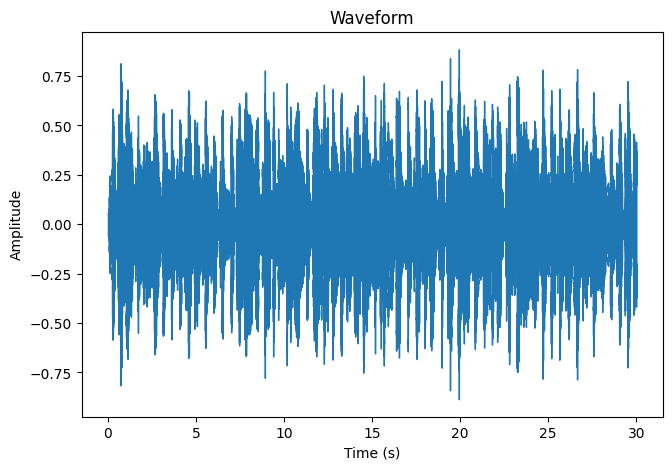

In [ ]:
FIG_SIZE = (7.5,5)

file = "/content/drive/MyDrive/Colab-Notebooks/AI-2024/Data/genres_original/blues/blues.00000.wav"

# load audio file usig Librosa
signal, sample_rate = librosa.load(file, sr=22050)

# Show waveform
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(signal, sr=sample_rate)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

Text(0.5, 1.0, 'Power spectrum')

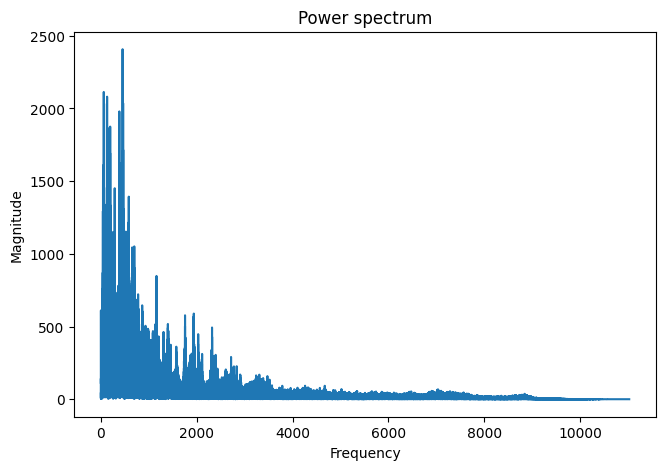

In [ ]:
# Fourier transform
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sample_rate, len(magnitude))

left_magnitude = magnitude[:int(len(magnitude)/2)]
left_frequency = frequency[:int(len(frequency)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

Text(0.5, 1.0, 'MFCCs')

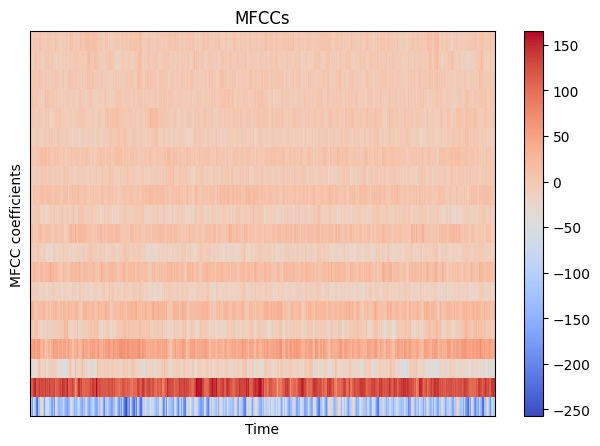

In [ ]:
# MFCCs
MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=20)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

Text(0.5, 1.0, 'Mel Spectrogram')

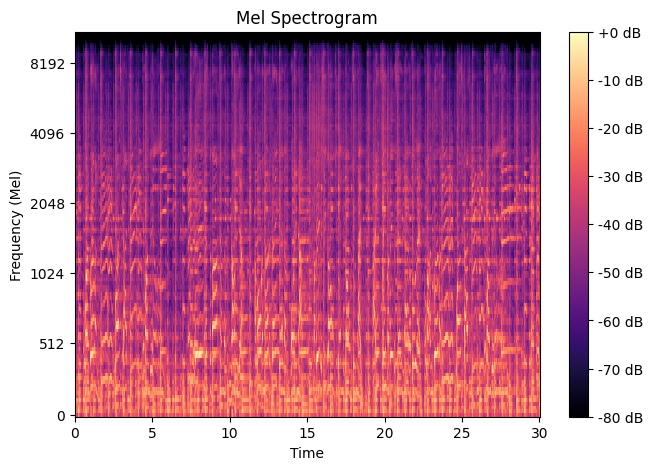

In [ ]:
# Mel spectrogram
n_fft = 2048
hop_length = 512
n_mels = 128

mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

# Convert Mel spectrogram to dB scale (log scale)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Display Mel spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.xlabel("Time")
plt.ylabel("Frequency (Mel)")
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")

## Music genre classification: Preparing the dataset

In [11]:
import json
import os
import math
import librosa

DATASET_PATH = "/content/drive/MyDrive/Colab-Notebooks/AI-2024/Data/genres_original"
OUTPUT_DIR = "/content/drive/MyDrive/Colab-Notebooks/AI-2024/Data/json_output"

SAMPLE_RATE = 22050
TRACK_DURATION = 30  # in secs
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [12]:
def dump_to_json(data, json_path):
    print("\nDumping data to file:", json_path)
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


In [ ]:
def get_mel_spectrogram_dictionary(dataset_path, output_dir, n_mels=128, n_fft=2048, hop_length=512, num_segments=10):
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mel_vectors_per_segment = math.ceil(samples_per_segment / hop_length)


    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath != dataset_path:
            # Save genre label (i.e., sub-folder name)
            genre_label = dirpath.split("/")[-1]
            genre_json_path = os.path.join(output_dir, genre_label + ".json")

            # Skip if JSON file already exists for this genre
            if os.path.exists(genre_json_path):
                print("JSON file already exists fo {}.".format(genre_label))
                continue

            genre_data = {"mel_spectrograms": []}
            processed_segments = 0  # Counter for processed segments
            print("\nProcessing: {}".format(genre_label))

            # Process all audio files in genre sub-dir
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                audio_length = librosa.get_duration(y=signal, sr=sample_rate)

                if audio_length < TRACK_DURATION:
                    # Calculate the amount of padding needed
                    padding_length = int((TRACK_DURATION - audio_length) * sample_rate)

                    # Pad the audio file with zeros
                    padded_signal = np.pad(signal, (0, padding_length), mode='constant')
                    signal = padded_signal

                elif audio_length > TRACK_DURATION:
                    # Trim the audio file to 30 seconds
                    signal = signal[:int(TRACK_DURATION * sample_rate)]

                # Process all segments of audio file
                for d in range(num_segments):
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # Extract mel-spectrogram
                    mel_spectrogram = librosa.feature.melspectrogram(
                        y=signal[start:finish],
                        sr=sample_rate,
                        n_mels=n_mels,
                        n_fft=n_fft,
                        hop_length=hop_length
                    )
                    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
                    mel_spectrogram = mel_spectrogram.T

                    # Store only mel-spectrogram feature with expected number of vectors
                    if len(mel_spectrogram) == num_mel_vectors_per_segment:
                        genre_data["mel_spectrograms"].append(mel_spectrogram.tolist())
                        processed_segments += 1  # Increment the counter
                    else:
                        print("Unexpected mel-spectrogram length:", len(mel_spectrogram))

            # Print the number of processed segments for the genre
            print("Processed segments for {}: {}".format(genre_label, processed_segments))

            # Dump genre data to a separate JSON file
            dump_to_json(genre_data, genre_json_path)



In [ ]:
# Call the function to process the dataset and save mel spectrograms for each genre to separate JSON files
get_mel_spectrogram_dictionary(DATASET_PATH, OUTPUT_DIR, num_segments=10)


Processing: reggae
Processed segments for reggae: 1000

Dumping data to file: /content/drive/MyDrive/Colab Notebooks/AI-2024/Data/json_output/reggae.json

Processing: metal
Processed segments for metal: 1000

Dumping data to file: /content/drive/MyDrive/Colab Notebooks/AI-2024/Data/json_output/metal.json

Processing: rock
Processed segments for rock: 1000

Dumping data to file: /content/drive/MyDrive/Colab Notebooks/AI-2024/Data/json_output/rock.json

Processing: blues
Processed segments for blues: 1000

Dumping data to file: /content/drive/MyDrive/Colab Notebooks/AI-2024/Data/json_output/blues.json

Processing: country
Processed segments for country: 1000

Dumping data to file: /content/drive/MyDrive/Colab Notebooks/AI-2024/Data/json_output/country.json

Processing: jazz
Processed segments for jazz: 1000

Dumping data to file: /content/drive/MyDrive/Colab Notebooks/AI-2024/Data/json_output/jazz.json

Processing: pop
Processed segments for pop: 1000

Dumping data to file: /content/dri

## Music genre classification: Implementing a CNN

In [4]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [5]:
from tensorflow.keras.utils import Sequence

# Custom data generator with additional augmentations
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, augment=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, len(self.X))
        indices = self.indices[start_index:end_index]

        X_batch = self.X[indices]
        y_batch = self.y[indices]

        if self.augment:
            X_batch = np.array([self.augment_data(x) for x in X_batch])

        return X_batch, y_batch

    def on_epoch_end(self):
        self.indices = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def augment_data(self, sample):
        if np.random.rand() < 0.5:
            sample = self.add_noise(sample)
        #if np.random.rand() < 0.5:
            #sample = self.time_shift(sample)
        #if np.random.rand() < 0.5:
            #sample = self.pitch_shift(sample)
        if np.random.rand() < 0.5:
            sample = self.time_stretch(sample)
        if np.random.rand() < 0.5:
            sample = self.frequency_mask(sample)
        #if np.random.rand() < 0.5:
            #sample = self.time_mask(sample)
        return sample

    def add_noise(self, sample):
        noise = np.random.normal(0, 0.02, sample.shape)
        return sample + noise

    def time_shift(self, sample):
        shift = np.random.randint(sample.shape[1])
        return np.roll(sample, shift, axis=1)

    def pitch_shift(self, sample):
        return librosa.effects.pitch_shift(sample, sr=22050, n_steps=np.random.randint(-5, 5))

    def time_stretch(self, sample):
        rate = np.random.uniform(0.8, 1.2)
        return librosa.effects.time_stretch(sample, rate)

    def frequency_mask(self, sample):
        freq_band = np.random.randint(0, sample.shape[0] // 2)
        sample[freq_band:freq_band + np.random.randint(1, sample.shape[0] // 2)] = 0
        return sample

    def time_mask(self, sample):
        time_band = np.random.randint(0, sample.shape[1] // 2)
        sample[:, time_band:time_band + np.random.randint(1, sample.shape[1] // 2)] = 0
        return sample

In [6]:
import os
import json
import numpy as np

def load_data(data_dir):
    X = []
    y = []
    label_list = []  # List to store genre labels

    # Iterate over each genre file in the data directory
    for file_name in os.listdir(data_dir):
        if file_name.endswith(".json"):
            genre_label = file_name.split(".")[0]  # Extract genre label from the file name
            label_list.append(genre_label)

            file_path = os.path.join(data_dir, file_name)

            # Load data from the JSON file
            with open(file_path, "r") as fp:
                genre_data = json.load(fp)

            # Add mel spectrograms to X and assign labels to y
            for mel_spectrogram in genre_data["mel_spectrograms"]:
                X.append(mel_spectrogram)
                y.append(label_list.index(genre_label))  # Append the index of the genre label

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Data successfully loaded!")

    return X, y, label_list


In [7]:
from sklearn.model_selection import train_test_split

def prepare_datasets(train_size, val_size, test_size):
    X, y, label_list = load_data(OUTPUT_DIR)

    # create train, validation and test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=val_size/(train_size+val_size), random_state=42, stratify=y_train)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, label_list


In [8]:
def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.BatchNormalization())

    # Flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(0.5))  # Increased dropout rate

    # Additional dropout layer
    model.add(keras.layers.Dropout(0.5))

    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


In [9]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")


    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.5)

    plt.show()

In [13]:
X_train, X_validation, X_test, y_train, y_validation, y_test, label_list = prepare_datasets(train_size=0.7, val_size=0.2, test_size=0.1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

Data successfully loaded!


In [14]:
training_generator = DataGenerator(X_train, y_train, batch_size=64, augment=True)
validation_generator = DataGenerator(X_validation, y_validation, batch_size=64, shuffle=False, augment=False)

In [15]:
model = build_model(input_shape)

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 63, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 63, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 61, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 30, 128)       0         
 g2D)                                                            
                                                        

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a ModelCheckpoint callback to save the best weights during training
checkpoint = ModelCheckpoint(filepath='best_weights.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Define other callbacks
callbacks = [
   EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True),
   ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6),
   checkpoint
]

# Train the model with callbacks
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), callbacks=callbacks, epochs=100)

# Load the best weights after training
model.load_weights('best_weights.h5')

print("Training completed !")



Epoch 1/100
219/219 [==============================] - ETA: 0s - loss: 2.1879 - accuracy: 0.3563
Epoch 1: val_accuracy improved from -inf to 0.42079, saving model to best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - 18s 50ms/step - loss: 2.1879 - accuracy: 0.3563 - val_loss: 1.5319 - val_accuracy: 0.4208 - lr: 1.0000e-04
Epoch 2/100
219/219 [==============================] - ETA: 0s - loss: 1.3546 - accuracy: 0.5471
Epoch 2: val_accuracy improved from 0.42079 to 0.69765, saving model to best_weights.h5
219/219 [==============================] - 9s 43ms/step - loss: 1.3546 - accuracy: 0.5471 - val_loss: 0.9259 - val_accuracy: 0.6977 - lr: 1.0000e-04
Epoch 3/100
219/219 [==============================] - ETA: 0s - loss: 1.0154 - accuracy: 0.6572
Epoch 3: val_accuracy improved from 0.69765 to 0.73963, saving model to best_weights.h5
219/219 [==============================] - 10s 43ms/step - loss: 1.0154 - accuracy: 0.6572 - val_loss: 0.7595 - val_accuracy: 0.7396 - lr: 1.0000e-04
Epoch 4/100
219/219 [==============================] - ETA: 0s - loss: 0.7753 - accuracy: 0.7345
Epoch 4: val_accuracy improved from 0.73963 to 0.75062, saving model to best_weights

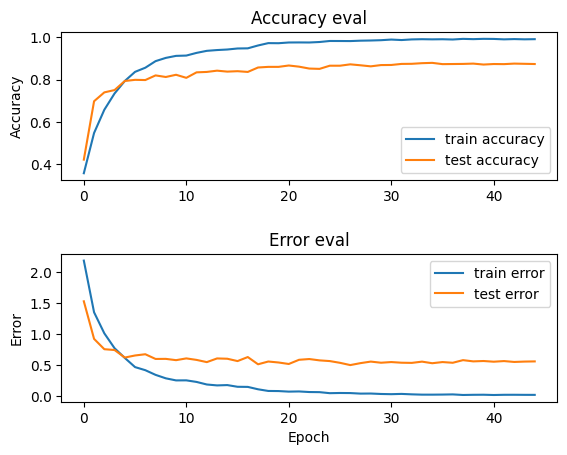

In [17]:
plot_history(history)

In [18]:
# Evaluation
test_generator = DataGenerator(X_test, y_test, batch_size=64, shuffle=False, augment=False)
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)


16/16 - 2s - loss: 0.5961 - accuracy: 0.8730 - 2s/epoch - 129ms/step
Test accuracy: 0.8730000257492065


In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already trained your model and obtained predictions
# Predictions should be obtained using the test data generator

# Initialize empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over each batch in the test generator
for i in range(len(test_generator)):
    # Obtain a batch of test data and true labels
    X_batch, y_batch = test_generator[i]

    # Predict labels for the batch
    batch_predictions = model.predict(X_batch, verbose=0)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)

    # Append true labels and predicted labels for the batch to the respective arrays
    true_labels.extend(y_batch)
    predicted_labels.extend(batch_predicted_labels)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=label_list))




Classification Report:
              precision    recall  f1-score   support

      reggae       0.98      0.85      0.91       100
       metal       0.86      0.94      0.90       100
        rock       0.78      0.74      0.76       100
       blues       0.89      0.90      0.90       100
     country       0.87      0.81      0.84       100
        jazz       0.95      0.91      0.93       100
         pop       0.79      0.92      0.85       100
       disco       0.84      0.80      0.82       100
   classical       0.94      0.98      0.96       100
      hiphop       0.85      0.88      0.86       100

    accuracy                           0.87      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000



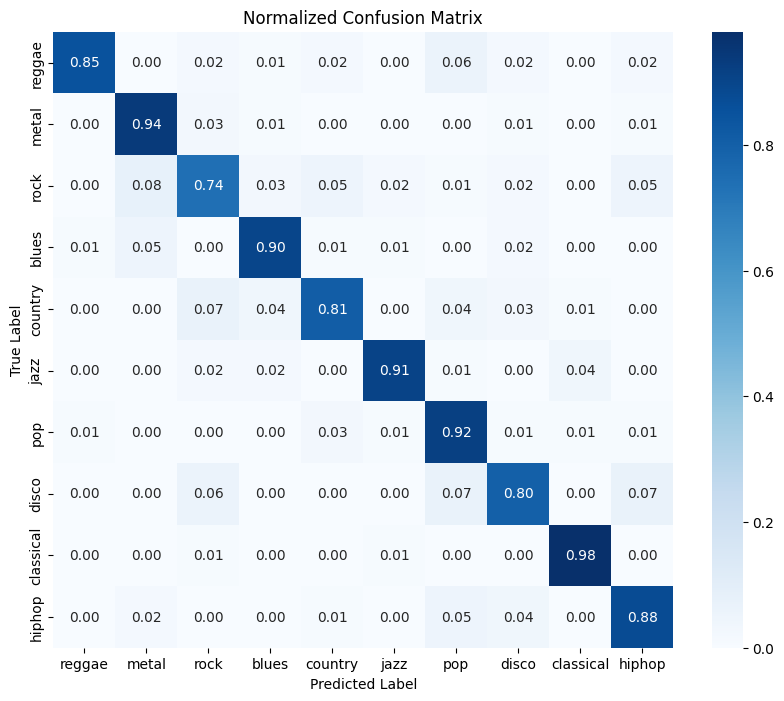

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Compute the total number of samples for each true label
total_samples_per_class = np.sum(cm, axis=1)

# Normalize the confusion matrix
normalized_cm = cm / total_samples_per_class[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt=".2f", xticklabels=label_list, yticklabels=label_list)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [21]:
model_path = os.path.join(OUTPUT_DIR, "trained_model.keras")
model.save(model_path)

## GitHub Commit

In [ ]:
%cd /content/drive/MyDrive/Colab-Notebooks/AI-2024/Music-Genre-Classification


/content/drive/MyDrive/Colab-Notebooks/AI-2024/Music-Genre-Classification


In [ ]:

!git config --global user.name "AyaSafan"
!git config --global user.email "ayasafan16@gmail.com"

!git rm -r --cached .
!git reset
!git add .
!git commit -m "Edi"
!git push origin master --force


rm 'MEL-Music-Genre-Classification.ipynb'
rm 'legacy/MFCC Music-Genre-Classification.ipynb'
Unstaged changes after reset:
M	MEL-Music-Genre-Classification.ipynb
[master d34b8b4] Edit audio sample
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite MEL-Music-Genre-Classification.ipynb (93%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 170.53 KiB | 2.84 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/AyaSafan/Music-Genre-Classification.git
   20073f2..d34b8b4  master -> master
